In [1]:
import functools
import io
import re
import glob
import tempfile
import math
import multiprocessing
import os

import numpy as np
import pandas as pd

import tensorflow as tf

import tensorflow_transform as tft
from tensorflow_transform.beam import impl as beam_impl
from tensorflow_transform.beam.tft_beam_io import transform_fn_io
from tensorflow_transform.tf_metadata import dataset_metadata, dataset_schema

import apache_beam as beam
from apache_beam.io import tfrecordio

from scipy.stats import truncnorm

from djr_py.tf.dataset import fetch_tf_records
from djr_py.tf.util import get_available_gpus

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(1)
np.random.seed(1)

In [3]:
get_available_gpus()

[u'/device:GPU:0']

In [4]:
# set some important variables\n",
TRAIN_PATH = 'data/train.tfrecord'
TRAIN_TRANSFORMED_PATH = 'data/train_transformed.tfrecord'
TEST_PATH = 'data/test.tfrecord'
TEST_TRANSFORMED_PATH = 'data/test_transformed.tfrecord'

TFT_OUT_PATH = 'tft_output'
MODEL_LOG = 'log'

In [5]:
# rebuild inputs
overwrite = False

### Download data

In [6]:
if overwrite:
    !gsutil cp gs://djr-data/movie-reviews/aclImdb_v1.tar.gz .
    !tar -xzf aclImdb_v1.tar.gz && rm aclImdb_v1.tar.gz

    !gsutil cp gs://djr-data/movie-reviews/glove.twitter.27B.zip .
    !unzip glove.twitter.27B.zip -d glove && rm glove.twitter.27B.zip

### Load data into TFRecords

NOTE: RE2 does not support constructs for which only backtracking solutions are known to exist. Thus, backreferences and look-around assertions are not supported!  As a result, I can't put this in tf.regex_replace(...), and it must live outside the input serving function.

In [7]:
# this pulls out our proper nouns and treats them as single words
def proper_preprocessing(review):
    proper = r"([A-Z]([a-z]+|\.)(?:\s+[A-Z]([a-z]+|\.))*(?:\s+[a-z][a-z\-]+){0,2}\s+[A-Z]([a-z]+|\.)(?:\s+[0-9]+)?)"
    space_between_brackets = r"[\.\s]+(?=[^\[\]]*]])"
    brackets = r"(?:[\[]{2})(.*?)(?:[\]]{2})"
    
    review = re.sub(proper, '[[\\1]]', review)
    review = re.sub(space_between_brackets, '~', review)
    review = re.sub(brackets, '\\1', review)
    return review

In [8]:
def load_data(g, out):
    inputs = glob.glob(g)
    np.random.shuffle(inputs)
    with tf.python_io.TFRecordWriter(out) as writer:
        for i in inputs:
            label = 1 if i.split('/')[2] == 'pos' else 0
            with open(i, 'r') as f:
                review = f.read()
            
            example = tf.train.Example()
            example.features.feature['review'].bytes_list.value.append(proper_preprocessing(review))
            example.features.feature['label'].int64_list.value.append(label)
                                
            writer.write(example.SerializeToString())

if not os.path.exists(TRAIN_PATH) or overwrite:
    load_data('aclImdb/train/[posneg]*/*.txt', TRAIN_PATH)

if not os.path.exists(TEST_PATH) or overwrite:
    load_data('aclImdb/test/[posneg]*/*.txt', TEST_PATH)

### Use TFT to preprocess data

In [9]:
# schema for raw data
RAW_DATA_FEATURE = {
    'review': tf.FixedLenFeature(shape=[1], dtype=tf.string),
    'label': tf.FixedLenFeature(shape=[1], dtype=tf.int64)
}

RAW_DATA_METADATA = dataset_metadata.DatasetMetadata(
    dataset_schema.from_feature_spec(RAW_DATA_FEATURE))

In [10]:
if overwrite:
    !rm -Rf $TFT_OUT_PATH/transform_fn 
    !rm -Rf $TFT_OUT_PATH/transformed_metadata

In [11]:
# train our tft transformer
if not os.path.exists('{}/transform_fn'.format(TFT_OUT_PATH)):
    with beam.Pipeline() as pipeline:
        with beam_impl.Context(temp_dir=tempfile.mkdtemp()):
            coder = tft.coders.ExampleProtoCoder(RAW_DATA_METADATA.schema)

            train_data = (
                pipeline
                | 'ReadTrain' >> tfrecordio.ReadFromTFRecord(TRAIN_PATH)
                | 'DecodeTrain' >> beam.Map(coder.decode))

            test_data = (
                pipeline
                | 'ReadTest' >> tfrecordio.ReadFromTFRecord(TEST_PATH)
                | 'DecodeTest' >> beam.Map(coder.decode))


            # remove links, tags, quotes, apostraphes
            # bracketize proper nouns, names, and numbers
            # then lowercase, split by punctuation, and remove low frequency words
            def preprocessing_fn(inputs):
                remove = '|'.join(["https?:\/\/(www\.)?([^\s]*)", "<([^>]+)>", "\'", "\""])
                punctuation = r"([.,;!?\(\)\/])+"
                number_commas = r"([0-9]),([0-9])"

                reviews = tf.reshape(inputs['review'], [-1])

                reviews = tf.regex_replace(reviews, remove, '')
                reviews = tf.regex_replace(tf.regex_replace(reviews, punctuation, ' \\1 '), r"\s+", ' ')
                reviews = tf.regex_replace(reviews, number_commas, '\\1\\2')

                for letter in list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
                    reviews = tf.regex_replace(reviews, letter, letter.lower())

                terms = tf.string_split(reviews, ' ')
                terms_indices = tft.compute_and_apply_vocabulary(terms, frequency_threshold=5, num_oov_buckets=1, vocab_filename='vocab')

                return {
                    'terms': terms,
                    'terms_indices': terms_indices,
                    'label': inputs['label']
                }


            (transformed_train_data, transformed_metadata), transform_fn = (
                (train_data, RAW_DATA_METADATA)
                | 'AnalyzeAndTransform' >> beam_impl.AnalyzeAndTransformDataset(preprocessing_fn))

            transformed_test_data, _ = (
                ((test_data, RAW_DATA_METADATA), transform_fn)
                | 'Transform' >> beam_impl.TransformDataset())

            transformed_data_coder = tft.coders.ExampleProtoCoder(transformed_metadata.schema)

            _ = (
                transformed_train_data
                | 'EncodeTrain' >> beam.Map(transformed_data_coder.encode)
                | 'WriteTrain' >> tfrecordio.WriteToTFRecord(TRAIN_TRANSFORMED_PATH))

            _ = (
                transformed_test_data
                | 'EncodeTest' >> beam.Map(transformed_data_coder.encode)
                | 'WriteTest' >> tfrecordio.WriteToTFRecord(TEST_TRANSFORMED_PATH))

            _ = (
                transform_fn
                | 'WriteTransformFn' >> transform_fn_io.WriteTransformFn(TFT_OUT_PATH))

In [12]:
# load tft object
tft_output = tft.TFTransformOutput(TFT_OUT_PATH)
feature_spec = tft_output.transformed_feature_spec()

In [13]:
# qc the preprocessing
wildcard = lambda x: '{}*'.format(x)

with tf.Session() as sess:
    qc1 = fetch_tf_records(TRAIN_PATH, RAW_DATA_FEATURE, top=10)
    qc2 = fetch_tf_records(wildcard(TRAIN_TRANSFORMED_PATH), feature_spec, top=10)
    qc2 = sess.run(tf.sparse_to_dense(qc2['terms'].indices, qc2['terms'].dense_shape, qc2['terms'].values, default_value=''))

qc1['review'][0], '|'.join(qc2[0].tolist())

(array(['There are so many stupid moments in \'Tower~of~Death\'/\'Game~of~Death~2\' that you really wonder if it\'s a spoof. At times, it felt like I was watching a sequel to Kung~Pow rather than a Bruce~Lee film.<br /><br />To be honest, this film has bugger all to do with \'Game~of~Death\'. If anything, it\'s more a sequel/remake of \'Enter~the~Dragon\', incorporating many elements of that film - particularly the actual footage. Bruce~Lee\'s character Billy~Lo (apparently) investigates the sudden death of his friend and encounters a piece of film that was left with the man\'s daughter. When the body is stolen during the funeral (!), Billy is also killed and it\'s up to his wayward brother to avenge both men\'s deaths.<br /><br />Tong~Long stars as brother Bobby~Lo and doesn\'t really have the sort of charisma to carry the film. His fighting abilities are very good however. Bruce~Lee obviously turns up thanks to (no longer) deleted footage simply to cash-in on the legacy. Saying that,

### Initialize word embeddings with [GloVe](https://nlp.stanford.edu/projects/glove/)

In [14]:
# get vocabulary
vocab = tft_output.vocabulary_by_name('vocab')
vocab_size = len(vocab)

In [15]:
# load glove embeddings
embedding_size = 200
glove_embeddings = {}

with open('glove/glove.twitter.27B.{}d.txt'.format(embedding_size), mode='r') as f:  
    for line in f:
        values = line.strip().split()
        w = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        glove_embeddings[w] = vectors

In [16]:
# create initialized embedding matrix
embedding_matrix = truncnorm.rvs(a=-2, b=2, size=(vocab_size+1, embedding_size))

glove_np = pd.DataFrame(glove_embeddings).values
glove_mu, glove_std = np.mean(glove_np), np.std(glove_np)
        
for i, w in enumerate(vocab):
    try:
        embedding_matrix[i] = np.clip((glove_embeddings[w] - glove_mu)/glove_std, -2, 2)
    except KeyError:
        pass

embedding_matrix = embedding_matrix / math.sqrt(embedding_size)
    
def embedding_initializer(shape=None, dtype=tf.float32, partition_info=None):  
    assert dtype is tf.float32
    return embedding_matrix

### Build classifier

In [17]:
# input function
def input_fn(input_file_pattern, num_epochs=None, batch_size=25, shuffle=True, prefetch=1):  
    input_file_names = glob.glob(input_file_pattern)
    
    ds = tf.data.TFRecordDataset(input_file_names)
    ds = ds.cache()

    if shuffle:
        ds = ds.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=1000, count=num_epochs))
    else:
        ds = ds.repeat(num_epochs)

    ds = ds.apply(tf.contrib.data.map_and_batch(
        map_func=lambda x: tf.parse_single_example(x, feature_spec), 
        batch_size=batch_size,
        num_parallel_calls=multiprocessing.cpu_count()
    ))
    
    if prefetch > 0:
        ds = ds.prefetch(prefetch)
    
    features = ds.make_one_shot_iterator().get_next()
    labels = features.pop('label')
    return features, labels

train_input_fn = functools.partial(input_fn,
                                   input_file_pattern=wildcard(TRAIN_TRANSFORMED_PATH),
                                   num_epochs=1)

test_input_fn = functools.partial(input_fn,
                                  input_file_pattern=wildcard(TEST_TRANSFORMED_PATH),
                                  num_epochs=1)

In [18]:
# create estimator spec
def make_model(features, labels, mode, params, config):

    # hyperparameters
    dropout = params['dropout']
    conv_filters = params['conv_filters']
    dense_units = params['dense_units']
    learning_rate_start = params['learning_rate_start']
    learning_rate_steps = params['learning_rate_steps']
    
    # flag if training
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    # set up feature columns
    terms = features['terms_indices']
    
    terms_shape = terms.dense_shape
    terms_shape = tf.stack([terms_shape[0], tf.where(terms_shape[1] < 3, tf.constant(3, dtype=tf.int64), terms_shape[1])], axis=0)

    terms = tf.sparse_to_dense(terms.indices, terms_shape, terms.values, default_value=vocab_size)
    terms_embed_seq = tf.contrib.layers.embed_sequence(terms, vocab_size=vocab_size+1, embed_dim=embedding_size, initializer=embedding_initializer)
    
    # build graph
    net = terms_embed_seq
    net = tf.layers.dropout(net, rate=dropout, training=is_training)
    net = tf.layers.conv1d(inputs=net, filters=conv_filters, kernel_size=3, strides=1, activation=tf.nn.leaky_relu)
    net = tf.reduce_max(input_tensor=net, axis=1)      
    net = tf.layers.dropout(net, rate=dropout, training=is_training)
    net = tf.layers.batch_normalization(net, training=is_training)
    net = tf.layers.dense(net, units=dense_units, activation=tf.nn.leaky_relu)
    logits = tf.layers.dense(net, 2)
    
    # compute predictions
    predicted_classes = tf.argmax(logits, 1)
    predicted_probs = tf.nn.softmax(logits)
    
    # generate predictions
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class': predicted_classes,
            'prob': predicted_probs
        }
        
        export_outputs = {
          'predict': tf.estimator.export.PredictOutput(outputs=predictions)
        }
        
        return tf.estimator.EstimatorSpec(mode, predictions=predictions, export_outputs=export_outputs)

    # compute loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # create training op with cosine annealing for learning rate
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_global_step()
        
        learning_rate = tf.train.cosine_decay(learning_rate=learning_rate_start, global_step=global_step, 
                                              alpha=0.05, decay_steps=learning_rate_steps)
        
        optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
        optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=global_step)
        
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

    # compute evaluation metrics
    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(labels=labels, predictions=predicted_classes),
        'auc': tf.metrics.auc(labels=labels, predictions=predicted_probs[:, 1])
    }
    return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Train classifier

In [19]:
# build classifier
!rm -Rf $MODEL_LOG

epoch_size = 25000
num_epochs = 5
batch_size = 10
num_steps = epoch_size * num_epochs / batch_size // 1000 * 1000

params = dict(
    dropout=0.2,
    conv_filters=500,
    dense_units=100,
    learning_rate_start=0.1,
    learning_rate_steps=num_steps
)

ckpt_config = tf.estimator.RunConfig(keep_checkpoint_max=num_epochs)

classifier = tf.estimator.Estimator(model_fn=make_model,
                                    params=params,
                                    model_dir=MODEL_LOG,
                                    config=ckpt_config)

In [20]:
# train classifier
train_stats = []
for i in range(num_epochs):
    print("Starting epoch {}/{}...".format(i+1, num_epochs))
    classifier.train(input_fn=lambda: train_input_fn(batch_size=batch_size))
    ckpt = classifier.latest_checkpoint()
    train_auc = classifier.evaluate(input_fn=lambda: train_input_fn())['auc']
    test_auc = classifier.evaluate(input_fn=lambda: test_input_fn())['auc']
    train_stats.append((ckpt, train_auc, test_auc))

train_stats = pd.DataFrame(train_stats, columns=['ckpt', 'train_auc', 'test_auc'])

Starting epoch 1/5...
Starting epoch 2/5...
Starting epoch 3/5...
Starting epoch 4/5...
Starting epoch 5/5...


### Evaluate classifier

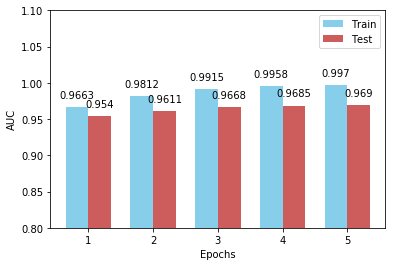

In [21]:
# plot train stats
ind = np.arange(len(train_stats)) + 1
width = 0.35

fig, ax = plt.subplots()
train_bar = ax.bar(ind - width/2, train_stats['train_auc'].round(4), width, color='SkyBlue', label='Train')
test_bar = ax.bar(ind + width/2, train_stats['test_auc'].round(4), width,  color='IndianRed', label='Test')

# adds labels to a bar chart series
def autolabel(ax, rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')

autolabel(ax, train_bar, "center")
autolabel(ax, test_bar, "center")

ax.set_ylabel('AUC')
ax.set_xlabel('Epochs')
ax.set_xticks(ind)
ax.legend()
ax.set_ylim(0.8, 1.1)

plt.show()

In [22]:
# overall stats
best_ckpt = train_stats.sort_values(by=['test_auc'], ascending=False)['ckpt'].values[0]

train_stats = classifier.evaluate(input_fn=train_input_fn, checkpoint_path=best_ckpt)
test_stats = classifier.evaluate(input_fn=test_input_fn, checkpoint_path=best_ckpt)

train_stats = pd.DataFrame.from_dict(train_stats, orient='index', columns=['train'])
test_stats = pd.DataFrame.from_dict(test_stats, orient='index', columns=['test'])
stats = train_stats.join(test_stats)
stats

,train,test
loss,0.088654,0.230451
auc,0.997005,0.969034
global_step,12500.000000,12500.000000
accuracy,0.973600,0.911200


### Export

In [23]:
def serving_input_fn():
    review = tf.placeholder(dtype=tf.string)
    label = tf.zeros(dtype=tf.int64, shape=[1, 1]) # just a placeholder
    
    transformed_features = tft_output.transform_raw_features({'review': review, 'label': label})
    
    return tf.estimator.export.ServingInputReceiver(transformed_features, {'review': review})


export_path = classifier.export_savedmodel(export_dir_base='exports',
                                           serving_input_receiver_fn=serving_input_fn,
                                           checkpoint_path=best_ckpt)

export_path = export_path.decode('utf-8')

In [24]:
!!venv/bin/saved_model_cli run --input_exprs 'review=["this is a terrible movie", "this is a great movie"]'  \
--dir $export_path --tag_set serve --signature_def predict

['2018-11-14 03:19:12.187746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero',
 '2018-11-14 03:19:12.188023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 0 with properties: ',
 'name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285',
 'pciBusID: 0000:00:04.0',
 'totalMemory: 15.90GiB freeMemory: 354.06MiB',
 '2018-11-14 03:19:12.188053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1484] Adding visible gpu devices: 0',
 '2018-11-14 03:19:12.567836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:965] Device interconnect StreamExecutor with strength 1 edge matrix:',
 '2018-11-14 03:19:12.567902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:971]      0 ',
 '2018-11-14 03:19:12.567913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] 0:   N ',
 '2018-11-14 03:19:12.568100: I tensor